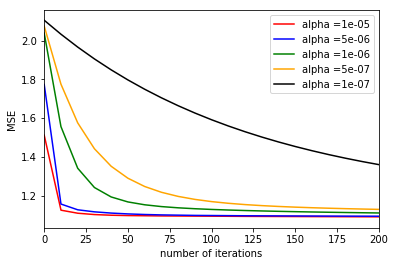

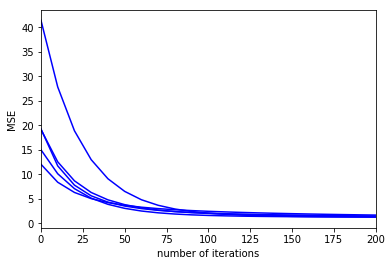

                            Train Performance  Validation Performance
No text feature                      1.084683                1.020327
60 MCW                               1.060429                0.983940
160 MCW                              1.047776                0.995069
60 MCW with extra features           1.045277                0.974438
All features                         1.032782                0.985008
                  Closed Form  Gradient Descent
Runtime low dim      0.000500          0.126085
MSE low dim          1.084683          1.086848
Runtime high dim     0.020046          0.397772
MSE high dim         1.047776          1.047975
1.2825331224983374


In [7]:
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt

from preprocess import preprocess
from feature_extraction import feature_extraction
from MSE import MSE
from GD import gradient_descent
from Linear_regression import Linear_regression


# Data preprocessing

# Load data in json format and store in a dataframe
with open("proj1_data.json") as fp:
    data = json.load(fp)
    df = pd.DataFrame(data)

# Convert true-false to 1-0
df["is_root"] = df["is_root"].astype(int)

# Convert all text to lower cases
df["text"]= [x.lower() for x in df["text"]]

# Parse text where there's a space
df["text"]= [x.split() for x in df["text"]]

# First 10000 data points as training set
train = df.iloc[0:10000,:]

# 10000 to 11000 as validation set
validation = df.iloc[10000:11000,:]
validation.index -= 10000

# Last 1000 as test set
test = df.iloc[11000:12000,:]
test.index -= 11000

# Preprocess the data
train, m_c_words = preprocess(train,160)
train = train.values.astype(float)
validation = feature_extraction(validation, m_c_words).values.astype(float)
test = feature_extraction(test, m_c_words).values.astype(float)


# Train Model

# Trains the Linear model on different set of features and compares their performance on the validation set
X_0 = train[:,0:4] # item start from 0 and end at (4-1)
X_60 = train[:,0:64]
X_160 = train[:,0:164]
extra_features = train[:,164:-1]
X_60_extra = np.concatenate((X_60, extra_features), axis=1)
X_all = train[:,0:-1]
y = train[:,-1]

# Trains a Linear model on each training set
w_optim_0, MSE_0 = Linear_regression(X_0, y,method = 0)
w_optim_60, MSE_60 = Linear_regression(X_60, y,method = 0)
w_optim_160, MSE_160 = Linear_regression(X_160, y,method = 0)
w_optim_60_extra, MSE_60_extra = Linear_regression(X_60_extra, y,method = 0)
w_optim, MSE_all = Linear_regression(X_all, y,method = 0)

# Select validations set corresponding to the different training set chosen above
val_0 = validation[:,0:4]
val_60 = validation[:,0:64]
val_160 = validation[:,0:164]
val_extra_features = validation[:,164:-1]
val_60_extra = np.concatenate((val_60, val_extra_features), axis=1)
val_all = validation[:,0:-1]
val_y = validation[:,-1]

# Mean squared error on validation sets
MSE_0_val = MSE(val_0, val_y, w_optim_0)
MSE_60_val = MSE(val_60, val_y, w_optim_60)
MSE_160_val = MSE(val_160, val_y, w_optim_160)
MSE_all_val = MSE(val_all, val_y, w_optim)
MSE_60_extra_val = MSE(val_60_extra, val_y, w_optim_60_extra)

# MSE comparison table
MSEs = [[MSE_0, MSE_0_val],[MSE_60, MSE_60_val],[MSE_160, MSE_160_val], [MSE_60_extra, MSE_60_extra_val], [MSE_all, MSE_all_val]]
MSE_table = pd.DataFrame(data=MSEs, columns = ['Train Performance','Validation Performance'],
                     index = ['No text feature','60 MCW', '160 MCW','60 MCW with extra features',
                              'All features'])

# Compares the runtime/stebility/performance of closed form vs gradient descent in high and low dimensional settings

# Closed Form low dimension
start_cf_ld = time.time()
MSE_cf_ld = Linear_regression(X_0, y, method=0)[1]
end_cf_ld = time.time()
time_cf_ld = end_cf_ld - start_cf_ld

# GD low dimension
start_gd_ld = time.time()
MSE_gd_ld = Linear_regression(X_0, y, None, alpha_0 = 1e-06, b = 0, eps = 1e-04)[1]
end_gd_ld = time.time()
time_gd_ld = end_gd_ld - start_gd_ld

# Closed Form high dimension
start_cf_hd = time.time()
MSE_cf_hd = Linear_regression(X_160, y, method=0)[1]
end_cf_hd = time.time()
time_cf_hd = end_cf_hd - start_cf_hd

# GD high dimension
start_gd_hd = time.time()
MSE_gd_hd = Linear_regression(X_160, y, None, alpha_0 = 5e-06, b = 0, eps = 1e-04)[1]
end_gd_hd = time.time()
time_gd_hd = end_gd_hd - start_gd_hd

# Runtime comparison table
runtime_table = pd.DataFrame(
    [[time_cf_ld, time_gd_ld], [MSE_cf_ld, MSE_gd_ld], [time_cf_hd, time_gd_hd], [MSE_cf_hd, MSE_gd_hd]],
     columns = ['Closed Form', 'Gradient Descent'], index=['Runtime low dim','MSE low dim', 'Runtime high dim', 'MSE high dim'])

# Compare different learning rate/beta for GD / plot
step_sizes = [1e-05, 5e-06, 1e-06, 5e-07, 1e-07]
initial_weights = np.random.uniform(-5, 5, (5, 4))

results_step_sizes = np.zeros((len(step_sizes)), dtype = np.ndarray)
results_initial_weights = np.zeros((initial_weights.shape[0]), dtype = np.ndarray)

for i in range(len(step_sizes)):
    results_step_sizes[i] = np.array(Linear_regression(X_0, y, method = 1, w_0 = None, alpha_0 = step_sizes[i], b = 0, eps = 1e-06)[2])

for i in range(initial_weights.shape[0]):
    results_initial_weights[i] = np.array(Linear_regression(X_0, y, method = 1, w_0 = initial_weights[i,:], alpha_0 = 1e-06, b = 0, eps = 1e-06)[2])

# Plots the different learning curves
colors = ["red", "blue", "green", "orange", "black"]

plt.figure(1)
for i in range(len(step_sizes)):
    plt.plot(np.linspace(0, 10 * len(results_step_sizes[i]), len(results_step_sizes[i])), 
             results_step_sizes[i], color = colors[i], label = 'alpha =' + str(step_sizes[i]))
plt.xlabel("number of iterations")
plt.ylabel("MSE")
plt.legend(loc='upper right')
plt.xlim(0,200)
plt.savefig('step_sizes.pdf')

plt.figure(2)
for i in range(initial_weights.shape[0]):
    plt.plot(np.linspace(0, 10 * len(results_initial_weights[i]), len(results_initial_weights[i])), results_initial_weights[i], color = "b")
plt.xlabel("number of iterations")
plt.ylabel("MSE")
plt.xlim(0,200)
plt.savefig('initial_weights.pdf')

# Run best model on test set
testset = np.concatenate((test[:,0:64],test[:,164:-1]),axis=1)
test_y = test[:,-1]
MSE_test = MSE(testset, test_y, w_optim_60_extra)

# returns the results
plt.show()
print(MSE_table)
print(runtime_table)
print(MSE_test)
